<a href="https://colab.research.google.com/github/joanby/trading-algoritmico-analisis-tecnico/blob/main/ES_TA_Cap%C3%ADtulo_06_Encontrar_los_mejores_assets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p><img alt="Colaboratory logo" height="45px" src="https://www.quantreo.com/wp-content/uploads/2021/10/Original-on-Transparent.png" align="left" hspace="10px" vspace="0px">
<img alt="Colaboratory logo" height="45px" src="https://static-881c.kxcdn.com/wp-content/uploads/2016/03/frogamesLogoFull4.png" align="left" hspace="10px" vspace="0px"></p>

# Encontrar los mejores assets
El objetivo será definir si ciertas clases de activos son más o menos adecuadas para la estrategia que proponemos.Estudiaremos varias clases: activos, criptomonedas, divisas. Luego estudiaremos diferentes características como el exponente de Hurst, la volatilidad, la beta.

### Contenido
* Todos los cálculos
* ¿Qué clase de activos es la mejor?
* Otros criterios óptimos

### Entorno

In [1]:
!pip install ta
!pip install yfinance
!pip install hurst

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for ta: filename=ta-0.10.1-py3-none-any.whl size=28985 sha256=fa0cdc337ee3396073ddce57acd6762274ed7b31dbcb540662e67a0e0d70c999
  Stored in directory: /root/.cache/pip/wheels/bc/2a/c2/a56e77d07edc16a1fa7fb012667e55cb0643cfa65996bddecc
Successfully built ta
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.1 MB/s 
     |████████████████████████████████| 6.4 MB 43.6 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. Th

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt

from matplotlib import cycler
colors = cycler('color',
                ['#669FEE', '#66EE91', '#9988DD',
                 '#EECC55', '#88BB44', '#FFBBBB'])
plt.rc('figure', facecolor='#313233')
plt.rc('axes', facecolor="#313233", edgecolor='none',
       axisbelow=True, grid=True, prop_cycle=colors,
       labelcolor='gray')
plt.rc('grid', color='474A4A', linestyle='solid')
plt.rc('xtick', color='gray')
plt.rc('ytick', direction='out', color='gray')
plt.rc('legend', facecolor="#313233", edgecolor="#313233")
plt.rc("text", color="#C9C9C9")
plt.rc('figure', facecolor='#313233')

In [8]:
import numpy as np
import pandas as pd

import yfinance as yf
from hurst import compute_Hc
import seaborn as sns

import ta
import warnings
from tqdm import tqdm

### Funciones

In [3]:
def RSI(val,neutral, window):
  """ 
        ------------------------------------------------------------------------------
        | Output: La función da los rendimientos de la estrategia RSI                |
        ------------------------------------------------------------------------------
        | Inputs: -val (type dataframe pandas): Valores de entrada de la acción      |
        |         -neutral (float): Valor neutral, es decir, zona de no acción       |
        |         -window (float): período de balanceo para el RSI                   |
        ------------------------------------------------------------------------------
  """

  # Print Error if there is no column Adj Close in the dataframe
  if "Adj Close" not in val.columns:
    ValueError("Necesitamos tener un nombre de columna Adj Close porque todos los cálculos se refieren a esta columna")
  
  val["rsi"] = ta.momentum.RSIIndicator(f["Adj Close"], window=window).rsi()

  
  """Señal de compra en largo """
  # Colocamos el umbral
  overbuy = 70
  neutral_buy = 50 + neutral

  # Poner valores nan para las columnas de la señal larga
  f["signal_long"] = np.nan
  f["yersteday_rsi"] = f["rsi"].shift(1)
  # Necesitamos definir la señal de apertura en largo (RSI ayer<55 y RSI hoy>55)
  f.loc[(f["rsi"]>neutral_buy) & (f["yersteday_rsi"]<neutral_buy), "signal_long"] = 1

  # Necesitamos definir la señal cierre en largo (RSI ayer>55 y RSI hoy<55) Señal falsa
  f.loc[(f["rsi"]<neutral_buy)&(f["yersteday_rsi"]>neutral_buy), "signal_long"] = 0

  # Necesitamos definir la señal cierre en largo (RSI ayer<70 y RSI hoy>70) Señal de sobrecompra
  f.loc[(f["rsi"]>overbuy)&(f["yersteday_rsi"]<overbuy), "signal_long"] = 0



  """Señal de venta en corto """
  # Colocamos el umbral
  oversell = 30
  neutral_sell = 50 - neutral

  # Poner valores nan para las columnas de la señal larga
  f["signal_short"] = np.nan
  f["yersteday_rsi"] = f["rsi"].shift(1)
  # Necesitamos definir la señal de apertura en corto (RSI ayer>45 y RSI hoy<45)
  f.loc[(f["rsi"]<neutral_sell) & (f["yersteday_rsi"]>neutral_sell), "signal_short"] = -1

  # Necesitamos definir la señal de cierre en corto (RSI ayer<45 y RSI hoy>45) Señal falsa
  f.loc[(f["rsi"]>neutral_sell)&(f["yersteday_rsi"]<neutral_sell), "signal_short"] = 0

  # Necesitamos definir la señal de cierre en corto (RSI ayer>30 y RSI hoy<30) Señal de sobre venta
  f.loc[(f["rsi"]<oversell)&(f["yersteday_rsi"]>oversell), "signal_short"] = 0

  """Calcular el retorno """
  # Calculamos el porcentaje de variación del activo
  val["pct"] = val["Adj Close"].pct_change(1)

  # Calculamos las posiciones
  val["Position"] = (val["signal_short"].fillna(method="ffill")+ val["signal_long"].fillna(method="ffill"))

  # Calculamos el valor de retorno de la estrategia
  val["return"] = val["pct"]*(val["Position"].shift(1))

  return val["return"]

In [4]:
def beta_function(serie):

  # Get SP500 data
  sp500 = yf.download("^GSPC")[["Adj Close"]].pct_change(1)

  # Change column name
  sp500.columns = ["SP500"]

  # Concatenate
  g = pd.concat((serie,sp500), axis=1)

  # Compute the beta
  beta = np.cov(g[[serie.name, "SP500"]].dropna().values,rowvar=False)[0][1] / np.var(g["SP500"].dropna().values)
  return beta


In [5]:
def drawdown_function(serie):

  # We compute Cumsum of the returns
  cum = serie.dropna().cumsum()+1

  # We compute max of the cumsum on the period (accumulate max)
  running_max = np.maximum.accumulate(cum)

  # We compute drawdown
  drawdown  = cum/running_max - 1 
  return drawdown

In [6]:
def BackTest(serie):

  # Import the benchmark
  sp500 = yf.download("^GSPC")["Adj Close"].pct_change(1)
  
  # Change the name
  sp500.name = "SP500"

  # Concat the returns and the sp500
  val = pd.concat((return_serie,sp500), axis=1).dropna()
  
  # Compute the drawdown
  drawdown = drawdown_function(serie)
  
  # Compute max drawdown
  max_drawdown = -np.min(drawdown)




  # Put a subplots
  fig, (cum, dra) = plt.subplots(1,2, figsize=(15,6))
  
  # Put a Suptitle
  fig.suptitle("Backtesting", size=20)

  # Returns cumsum chart
  cum.plot(serie.cumsum(), color="#39B3C7")

  # SP500 cumsum chart
  cum.plot(val["SP500"].cumsum(), color="#B85A0F")

  # Put a legend
  cum.legend(["Portfolio", "SP500"])
  
  # Set individual title
  cum.set_title("Cumulative Return", size=13)

  # Put the drawdown
  dra.fill_between(drawdown.index,0,drawdown, color="#C73954", alpha=0.65)

  # Set individual title
  dra.set_title("Drawdown", size=13)

  # Plot the graph
  plt.show()




  # Compute the sortino
  sortino = np.sqrt(252) * serie.mean()/serie.loc[serie<0].std()

  # Compute the beta
  beta = np.cov(val[["return", "SP500"]].values,rowvar=False)[0][1] / np.var(val["SP500"].values)

  # Compute the alpha
  alpha = 252*serie.mean() - 252*beta*serie.mean()

  # Print the statistics
  print(f"Sortino: {np.round(sortino,3)}")
  print(f"Beta: {np.round(beta,3)}")
  print(f"Alpha: {np.round(alpha,3)}")
  print(f"MaxDrawdown: {np.round(max_drawdown*100,3)} %")

# Sección 1:  Cálculos

### ¿Qué es el Exponente Hurst

El exponente de Hurst es un estadístico que ayuda a entender el comportamiento de una TimeSeries.

* 0.5< Hurst <1: Movimiento de tendencia
* 0.5 = Hurst: Movimiento aleatorio
* 0<Hurst<0.5: Movimiento antipersitente

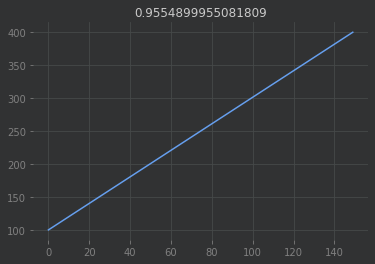

In [9]:
# Trending
# Compute Hurst Exponent
arr = np.linspace(0,300,150)+100
hurst = compute_Hc(arr)[0]

# Show the results
plt.plot(arr)
plt.title(f"{hurst}")
plt.show()

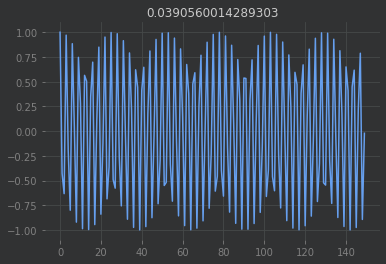

In [10]:
# Antipersistent
# Compute Hurst Exponent
arr = np.cos(np.linspace(0,300,150))
hurst = compute_Hc(arr)[0]

# Show the results
plt.plot(arr)
plt.title(f"{hurst}")
plt.show()

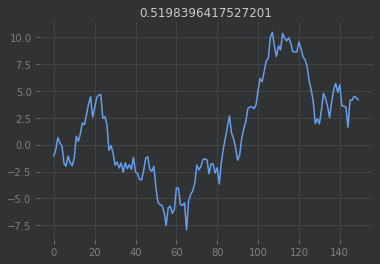

In [11]:
# Random
# Compute Hurst Exponent
np.random.seed(56)
arr = np.cumsum(np.random.randn(150))
hurst = compute_Hc(arr)[0]

# Show the results
plt.plot(arr)
plt.title(f"{hurst}")
plt.show()

### Cálculos

In [13]:
# We dowload Names.csv because it contains many yahoo ticler
assets = pd.read_csv("/content/Names.csv")["Symbol"]

# Initialize our lists
Statistics = []
col = []

for fin in tqdm(assets):

  # We put try for the asset which have less than 100 values
  try:
    print(fin)
    
    # We download data for each asset
    f = yf.download(fin).dropna()

    # Create a list to put the following statistics
    statistics = list()

    # Compute the Hurst
    statistics.append(compute_Hc(f["Adj Close"])[0])

    # Compute the volatility
    statistics.append(np.sqrt(252)*f["Adj Close"].pct_change(1).dropna().std())

    # Compute the beta
    statistics.append(beta_function(f["Adj Close"].pct_change(1).dropna()))

    # Compute strat return
    statistics.append(RSI(f,5,14).mean()*252)

    # Put statistics list in Statistics to have a list of lists
    Statistics.append(statistics)
    
    # Put column name in the list because some columns dont have 100 values
    col.append(fin)
  
  # If the assets has not 100 values we pass to the next
  except:
    pass


# We create dataframe with all the previous statistics
resume = pd.DataFrame(Statistics, columns=["Hurst", "Volatility", "Beta", "Sum strategy Returns"], index=col)
resume

  0%|          | 0/152 [00:00<?, ?it/s]

EURUSD=X
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

  1%|          | 1/152 [00:00<01:58,  1.27it/s]


EURGBP=X
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

  1%|▏         | 2/152 [00:01<01:54,  1.31it/s]


EURCHF=X
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

  2%|▏         | 3/152 [00:02<01:54,  1.30it/s]


EURCAD=X
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

  3%|▎         | 4/152 [00:03<01:51,  1.33it/s]


EURCNY=X
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

  3%|▎         | 5/152 [00:03<01:45,  1.39it/s]


EURJPY=X
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

  4%|▍         | 6/152 [00:04<01:46,  1.37it/s]


EURSEK=X
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

  5%|▍         | 7/152 [00:05<01:44,  1.39it/s]


EURHUF=X
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

  5%|▌         | 8/152 [00:05<01:41,  1.42it/s]


GBPUSD=X
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

  6%|▌         | 9/152 [00:06<01:41,  1.40it/s]


GBPCNY=X
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

  7%|▋         | 10/152 [00:07<01:38,  1.44it/s]


GBPJPY=X
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

  7%|▋         | 11/152 [00:07<01:39,  1.42it/s]


USDCHF=X
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

  8%|▊         | 12/152 [00:08<01:38,  1.42it/s]


USDCAD=X
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

  9%|▊         | 13/152 [00:09<01:39,  1.40it/s]


USDCNY=X
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

  9%|▉         | 14/152 [00:10<01:39,  1.39it/s]


USDHKD=X
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 10%|▉         | 15/152 [00:10<01:38,  1.39it/s]


USDSGD=X
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 11%|█         | 16/152 [00:11<01:38,  1.39it/s]


USDINR=X
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 11%|█         | 17/152 [00:12<01:37,  1.39it/s]


USDMXN=X
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 12%|█▏        | 18/152 [00:13<01:37,  1.37it/s]


USDPHP=X
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 12%|█▎        | 19/152 [00:13<01:35,  1.40it/s]


USDTHB=X
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 13%|█▎        | 20/152 [00:14<01:26,  1.53it/s]


USDMYR=X
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 14%|█▍        | 21/152 [00:14<01:27,  1.50it/s]


USDZAR=X
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 14%|█▍        | 22/152 [00:15<01:27,  1.49it/s]


USDJPY=X
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 15%|█▌        | 23/152 [00:16<01:30,  1.43it/s]


AUDJPY=X
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 16%|█▌        | 24/152 [00:17<01:28,  1.45it/s]


NZDUSD=X
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 16%|█▋        | 25/152 [00:17<01:30,  1.41it/s]


BTC-USD
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 17%|█▋        | 26/152 [00:18<01:26,  1.46it/s]


ETH-USD
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 18%|█▊        | 27/152 [00:19<01:23,  1.50it/s]


BNB-USD
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 18%|█▊        | 28/152 [00:19<01:19,  1.56it/s]


USDT-USD
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 19%|█▉        | 29/152 [00:20<01:17,  1.59it/s]


XRP-USD
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 20%|█▉        | 30/152 [00:20<01:17,  1.58it/s]


ADA-USD
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 20%|██        | 31/152 [00:21<01:16,  1.57it/s]


DOGE-USD
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 21%|██        | 32/152 [00:22<01:18,  1.53it/s]


DOT1-USD
[*********************100%***********************]  1 of 1 completed

 22%|██▏       | 33/152 [00:22<00:58,  2.04it/s]


UNI3-USD
[*********************100%***********************]  1 of 1 completed

 22%|██▏       | 34/152 [00:22<00:44,  2.64it/s]


LTC-USD
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 23%|██▎       | 35/152 [00:23<00:56,  2.08it/s]


BCH-USD
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 24%|██▎       | 36/152 [00:23<01:01,  1.88it/s]


LINK-USD
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 24%|██▍       | 37/152 [00:24<01:03,  1.80it/s]


VET-USD
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 25%|██▌       | 38/152 [00:24<01:04,  1.76it/s]


USDC-USD
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 26%|██▌       | 39/152 [00:25<01:06,  1.69it/s]


SOL1-USD
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 26%|██▋       | 40/152 [00:26<01:05,  1.72it/s]


XLM-USD
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 27%|██▋       | 41/152 [00:26<01:07,  1.65it/s]


FIL-USD
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 28%|██▊       | 42/152 [00:27<01:06,  1.65it/s]


THETA-USD
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 28%|██▊       | 43/152 [00:28<01:07,  1.62it/s]


TRX-USD
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 29%|██▉       | 44/152 [00:28<01:06,  1.62it/s]


XMR-USD
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 30%|██▉       | 45/152 [00:29<01:07,  1.59it/s]


LUNA1-USD
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 30%|███       | 46/152 [00:30<01:06,  1.59it/s]


NEO-USD
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 31%|███       | 47/152 [00:30<01:05,  1.60it/s]


EOS-USD
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 32%|███▏      | 48/152 [00:31<01:04,  1.62it/s]


MIOTA-USD
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 32%|███▏      | 49/152 [00:31<01:02,  1.64it/s]


BSV-USD
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 33%|███▎      | 50/152 [00:32<01:04,  1.59it/s]


AAPL
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 34%|███▎      | 51/152 [00:33<01:13,  1.38it/s]


MSFT
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 34%|███▍      | 52/152 [00:34<01:15,  1.33it/s]


AMZN
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 35%|███▍      | 53/152 [00:35<01:14,  1.33it/s]


TSLA
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 36%|███▌      | 54/152 [00:35<01:09,  1.41it/s]


FB
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 36%|███▌      | 55/152 [00:36<01:06,  1.46it/s]


GOOG
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 37%|███▋      | 56/152 [00:36<01:05,  1.47it/s]


GOOGL
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 38%|███▊      | 57/152 [00:37<01:05,  1.46it/s]


NVDA
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 38%|███▊      | 58/152 [00:38<01:05,  1.44it/s]


PYPL
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 39%|███▉      | 59/152 [00:38<01:01,  1.52it/s]


INTC
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 39%|███▉      | 60/152 [00:39<01:07,  1.37it/s]


CMCSA
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 40%|████      | 61/152 [00:40<01:11,  1.27it/s]


NFLX
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 41%|████      | 62/152 [00:41<01:08,  1.31it/s]


ADBE
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 41%|████▏     | 63/152 [00:42<01:09,  1.27it/s]


CSCO
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 42%|████▏     | 64/152 [00:43<01:10,  1.25it/s]


PEP
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 43%|████▎     | 65/152 [00:44<01:15,  1.16it/s]


AVGO
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 43%|████▎     | 66/152 [00:44<01:08,  1.26it/s]


TXN
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 44%|████▍     | 67/152 [00:45<01:15,  1.12it/s]


TMUS
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 45%|████▍     | 68/152 [00:46<01:09,  1.20it/s]


COST
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 45%|████▌     | 69/152 [00:47<01:08,  1.21it/s]


QCOM
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 46%|████▌     | 70/152 [00:48<01:07,  1.22it/s]


AMGN
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 47%|████▋     | 71/152 [00:49<01:07,  1.20it/s]


SBUX
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 47%|████▋     | 72/152 [00:49<01:05,  1.22it/s]


AMAT
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 48%|████▊     | 73/152 [00:50<01:05,  1.20it/s]


CHTR
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 49%|████▊     | 74/152 [00:51<01:00,  1.28it/s]


INTU
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 49%|████▉     | 75/152 [00:52<00:58,  1.31it/s]


MU
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 50%|█████     | 76/152 [00:52<00:59,  1.28it/s]


BKNG
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 51%|█████     | 77/152 [00:53<00:57,  1.29it/s]


AMD
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 51%|█████▏    | 78/152 [00:54<00:54,  1.37it/s]


LRCX
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 52%|█████▏    | 79/152 [00:55<00:57,  1.27it/s]


ISRG
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 53%|█████▎    | 80/152 [00:55<00:56,  1.29it/s]


MDLZ
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 53%|█████▎    | 81/152 [00:56<00:54,  1.30it/s]


GILD
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 54%|█████▍    | 82/152 [00:57<00:54,  1.27it/s]


FISV
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 55%|█████▍    | 83/152 [00:58<00:56,  1.23it/s]


ADP
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 55%|█████▌    | 84/152 [00:59<00:59,  1.14it/s]


ZM
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 56%|█████▌    | 85/152 [00:59<00:52,  1.28it/s]


MELI
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 57%|█████▋    | 86/152 [01:00<00:50,  1.32it/s]


ATVI
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 57%|█████▋    | 87/152 [01:01<00:49,  1.30it/s]


CSX
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 58%|█████▊    | 88/152 [01:02<00:52,  1.23it/s]


JD
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 59%|█████▊    | 89/152 [01:03<00:48,  1.31it/s]


ADSK
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 59%|█████▉    | 90/152 [01:03<00:47,  1.29it/s]


BIDU
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 60%|█████▉    | 91/152 [01:04<00:45,  1.34it/s]


ILMN
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 61%|██████    | 92/152 [01:05<00:43,  1.37it/s]


ADI
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 61%|██████    | 93/152 [01:06<00:45,  1.30it/s]


NXPI
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 62%|██████▏   | 94/152 [01:06<00:41,  1.39it/s]


VRTX
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 62%|██████▎   | 95/152 [01:07<00:41,  1.36it/s]


KLAC
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 63%|██████▎   | 96/152 [01:08<00:44,  1.27it/s]


MRNA
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 64%|██████▍   | 97/152 [01:08<00:39,  1.40it/s]


PDD
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 64%|██████▍   | 98/152 [01:09<00:37,  1.45it/s]


REGN
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 65%|██████▌   | 99/152 [01:10<00:37,  1.41it/s]


KHC
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 66%|██████▌   | 100/152 [01:11<00:37,  1.40it/s]


MNST
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 66%|██████▋   | 101/152 [01:11<00:37,  1.37it/s]


KDP
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 67%|██████▋   | 102/152 [01:12<00:36,  1.38it/s]


MAR
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 68%|██████▊   | 103/152 [01:13<00:36,  1.34it/s]


ASML
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 68%|██████▊   | 104/152 [01:14<00:36,  1.33it/s]


WBA
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 69%|██████▉   | 105/152 [01:14<00:37,  1.25it/s]


WDAY
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 70%|██████▉   | 106/152 [01:15<00:34,  1.34it/s]


ROST
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 70%|███████   | 107/152 [01:16<00:35,  1.29it/s]


ALGN
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 71%|███████   | 108/152 [01:17<00:32,  1.33it/s]


EXC
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 72%|███████▏  | 109/152 [01:18<00:35,  1.21it/s]


MCHP
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 72%|███████▏  | 110/152 [01:18<00:34,  1.23it/s]


AEP
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 73%|███████▎  | 111/152 [01:19<00:35,  1.15it/s]


EBAY
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 74%|███████▎  | 112/152 [01:20<00:32,  1.22it/s]


CTSH
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 74%|███████▍  | 113/152 [01:21<00:30,  1.28it/s]


IDXX
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 75%|███████▌  | 114/152 [01:22<00:29,  1.30it/s]


BIIB
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 76%|███████▌  | 115/152 [01:22<00:27,  1.32it/s]


EA
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 76%|███████▋  | 116/152 [01:23<00:27,  1.31it/s]


CDNS
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 77%|███████▋  | 117/152 [01:24<00:26,  1.31it/s]


SNPS
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 78%|███████▊  | 118/152 [01:25<00:25,  1.32it/s]


LULU
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 78%|███████▊  | 119/152 [01:25<00:24,  1.36it/s]


MTCH
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 79%|███████▉  | 120/152 [01:26<00:23,  1.33it/s]


DOCU
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 80%|███████▉  | 121/152 [01:27<00:21,  1.42it/s]


XEL
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 80%|████████  | 122/152 [01:28<00:23,  1.28it/s]


CTAS
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 81%|████████  | 123/152 [01:28<00:23,  1.24it/s]


ORLY
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 82%|████████▏ | 124/152 [01:29<00:22,  1.25it/s]


DXCM
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 82%|████████▏ | 125/152 [01:30<00:20,  1.34it/s]


PAYX
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 83%|████████▎ | 126/152 [01:31<00:20,  1.24it/s]


MRVL
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 84%|████████▎ | 127/152 [01:32<00:19,  1.27it/s]


ALXN
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- ALXN: No data found, symbol may be delisted
PCAR
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 85%|████████▍ | 129/152 [01:33<00:15,  1.49it/s]


NTES
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 86%|████████▌ | 130/152 [01:33<00:14,  1.48it/s]


XLNX
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- XLNX: No data found, symbol may be delisted
SWKS
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 87%|████████▋ | 132/152 [01:34<00:11,  1.67it/s]


ANSS
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 88%|████████▊ | 133/152 [01:35<00:11,  1.59it/s]


PTON
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 88%|████████▊ | 134/152 [01:36<00:11,  1.61it/s]


TEAM
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 89%|████████▉ | 135/152 [01:36<00:10,  1.63it/s]


VRSK
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 89%|████████▉ | 136/152 [01:37<00:10,  1.55it/s]


FAST
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 90%|█████████ | 137/152 [01:38<00:10,  1.44it/s]


OKTA
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 91%|█████████ | 138/152 [01:38<00:09,  1.47it/s]


DLTR
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 91%|█████████▏| 139/152 [01:39<00:09,  1.43it/s]


CPRT
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 92%|█████████▏| 140/152 [01:40<00:08,  1.40it/s]


SGEN
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 93%|█████████▎| 141/152 [01:41<00:07,  1.39it/s]


SIRI
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 93%|█████████▎| 142/152 [01:41<00:07,  1.37it/s]


MXIM
[*********************100%***********************]  1 of 1 completed

 94%|█████████▍| 143/152 [01:42<00:04,  1.84it/s]



1 Failed download:
- MXIM: No data found, symbol may be delisted
CDW
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 95%|█████████▍| 144/152 [01:42<00:04,  1.74it/s]


VRSN
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 95%|█████████▌| 145/152 [01:43<00:04,  1.60it/s]


SPLK
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 96%|█████████▌| 146/152 [01:44<00:03,  1.54it/s]


CERN
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 97%|█████████▋| 147/152 [01:44<00:03,  1.44it/s]


TCOM
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 97%|█████████▋| 148/152 [01:45<00:02,  1.44it/s]


INCY
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 98%|█████████▊| 149/152 [01:46<00:02,  1.39it/s]


CHKP
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 99%|█████████▊| 150/152 [01:47<00:01,  1.41it/s]


FOXA
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

 99%|█████████▉| 151/152 [01:47<00:00,  1.46it/s]


FOX
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

100%|██████████| 152/152 [01:48<00:00,  1.40it/s]

,Hurst,Volatility,Beta,Sum strategy Returns
EURUSD=X,0.441727,0.116070,0.122076,-0.013601
EURGBP=X,0.513059,0.082312,-0.032076,-0.025986
EURCHF=X,0.541544,0.078505,0.093811,-0.006617
EURCAD=X,0.452199,0.091716,-0.080930,-0.024679
EURCNY=X,0.458516,0.128925,0.066979,-0.107109
...,...,...,...,...
TCOM,0.523426,0.517341,1.731127,0.013758
INCY,0.502791,0.652601,1.928003,0.060660
CHKP,0.490355,0.516524,1.734381,-0.028498
FOXA,0.506095,0.372585,1.853924,-0.000956


In [14]:
# Extraemos la clase del activo
clustering = pd.read_csv("/content/Names.csv", index_col="Symbol")
del clustering["Unnamed: 0"]
clustering

,dummy
Symbol,
EURUSD=X,Currency
EURGBP=X,Currency
EURCHF=X,Currency
EURCAD=X,Currency
EURCNY=X,Currency
...,...
TCOM,Asset
INCY,Asset
CHKP,Asset


In [15]:
# Concatenamos el resultado para tener la clase de los activos
g = pd.concat((resume,clustering), axis=1).dropna()

In [16]:
g

,Hurst,Volatility,Beta,Sum strategy Returns,dummy
EURUSD=X,0.441727,0.116070,0.122076,-0.013601,Currency
EURGBP=X,0.513059,0.082312,-0.032076,-0.025986,Currency
EURCHF=X,0.541544,0.078505,0.093811,-0.006617,Currency
EURCAD=X,0.452199,0.091716,-0.080930,-0.024679,Currency
EURCNY=X,0.458516,0.128925,0.066979,-0.107109,Currency
...,...,...,...,...,...
TCOM,0.523426,0.517341,1.731127,0.013758,Asset
INCY,0.502791,0.652601,1.928003,0.060660,Asset
CHKP,0.490355,0.516524,1.734381,-0.028498,Asset
FOXA,0.506095,0.372585,1.853924,-0.000956,Asset


# Sección 2: ¿Cuales son los mejores activos?


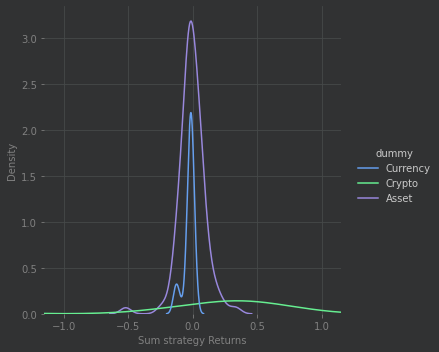

In [17]:
# We are going to plot the density of the strategy returns by the classe of the assets

# Plot the densities
sns.displot(data=g, x="Sum strategy Returns", kind="kde", hue="dummy")

# Limit the axis
plt.xlim((-1.15,1.15))

# plot the graph
plt.show()

In [18]:
# Describe by currency
g.loc[g["dummy"]=="Currency"].describe()

,Hurst,Volatility,Beta,Sum strategy Returns
count,25.000000,25.000000,25.000000,25.000000
mean,0.503835,0.099627,0.011017,-0.027489
std,0.050966,0.035529,0.184256,0.040261
min,0.391140,0.010720,-0.404365,-0.138172
25%,0.477528,0.082312,-0.080930,-0.025986
50%,0.496450,0.093946,0.000181,-0.020541
75%,0.541544,0.124683,0.108251,-0.004593
max,0.641198,0.173119,0.450787,0.020571


In [19]:
# Describe by Crypto
g.loc[g["dummy"]=="Crypto"].describe()

,Hurst,Volatility,Beta,Sum strategy Returns
count,23.000000,23.000000,23.000000,23.000000
mean,0.504118,1.075935,1.794347,0.218709
std,0.043385,0.485515,0.763798,0.510452
min,0.397426,0.062102,-0.092134,-1.631224
25%,0.490493,0.898683,1.712078,0.020071
50%,0.517602,1.068684,2.023940,0.296735
75%,0.531039,1.226390,2.362565,0.470603
max,0.562516,2.379917,2.723686,0.818905


In [20]:
# Describe by asset
g.loc[g["dummy"]=="Asset"].describe()

,Hurst,Volatility,Beta,Sum strategy Returns
count,99.000000,99.000000,99.000000,99.000000
mean,0.556837,0.462921,1.565736,-0.006536
std,0.034369,0.141418,0.404409,0.102456
min,0.485217,0.207810,0.636149,-0.518831
25%,0.531800,0.358871,1.269315,-0.048343
50%,0.558388,0.472720,1.572131,-0.014014
75%,0.580159,0.561123,1.856126,0.048422
max,0.643105,0.824805,2.651315,0.334187


# Sección 3: Otros criterios óptimos

In [21]:
g.describe()

,Hurst,Volatility,Beta,Sum strategy Returns
count,147.000000,147.000000,147.000000,147.000000
mean,0.539575,0.497050,1.337097,0.025143
std,0.046069,0.360247,0.756810,0.231587
min,0.391140,0.010720,-0.404365,-1.631224
25%,0.513154,0.286459,0.958707,-0.046142
50%,0.542303,0.463048,1.520667,-0.008309
75%,0.571538,0.582435,1.865085,0.058965
max,0.643105,2.379917,2.723686,0.818905


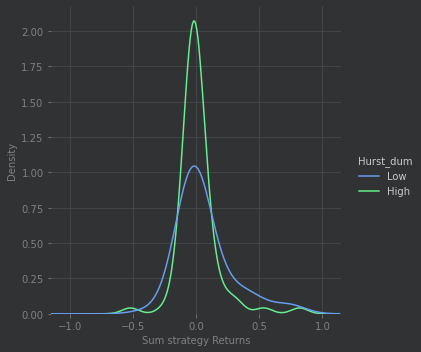

In [22]:
# We are going to plot the density of the strategy returns by the HURST
g["Hurst_dum"] = "Low"
g.loc[g["Hurst"]>0.54, "Hurst_dum"] = "High"

# Plot the densities
sns.displot(data=g, x="Sum strategy Returns", kind="kde", hue="Hurst_dum")

# Limit the axis
plt.xlim((-1.15,1.15))

# plot the graph
plt.show()

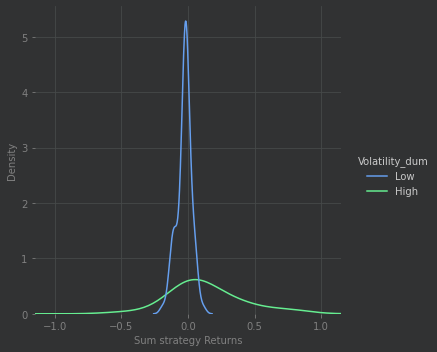

In [23]:
# We are going to plot the density of the strategy returns by the classe of the assets
g["Volatility_dum"] = "Low"
g.loc[g["Volatility"]>0.50,"Volatility_dum"] = "High"
# Plot the densities
sns.displot(data=g, x="Sum strategy Returns", kind="kde", hue="Volatility_dum")

# Limit the axis
plt.xlim((-1.15,1.15))

# plot the graph
plt.show()

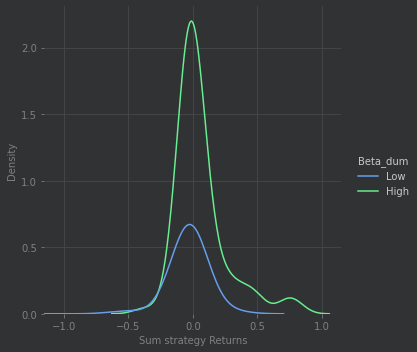

In [24]:
# We are going to plot the density of the strategy returns by the classe of the assets
g["Beta_dum"] = "Low"
g.loc[g["Beta"]>1,"Beta_dum"] = "High"
# Plot the densities
sns.displot(data=g, x="Sum strategy Returns", kind="kde", hue="Beta_dum")

# Limit the axis
plt.xlim((-1.15,1.15))

# plot the graph
plt.show()